# Crack Dataset

In [165]:
import torch
from torch import nn
from torch import optim
import glob
import os
import scipy.io as scio
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2
import seaborn

dataset_path = '/nfs4-p1/gj/datasets/AnomalyDetection/CrackForest'
gt_path = '/nfs4-p1/gj/datasets/AnomalyDetection/CrackForest/groundTruth'
image_path = '/nfs4-p1/gj/datasets/AnomalyDetection/CrackForest/image'


In [166]:
# read GT.mat
sample = os.path.join(gt_path , '001.mat')
gt = scio.loadmat(sample)
print(type(gt))
print(list(gt.keys()))

<class 'dict'>
['__header__', '__version__', '__globals__', 'groundTruth']


In [167]:
gt['groundTruth']

array([[(array([[1, 1, 1, ..., 1, 1, 1],
               [1, 1, 1, ..., 1, 1, 1],
               [1, 1, 1, ..., 1, 1, 1],
               ...,
               [1, 1, 1, ..., 1, 1, 1],
               [1, 1, 1, ..., 1, 1, 1],
               [1, 1, 1, ..., 1, 1, 1]], dtype=uint8), array([[0, 0, 0, ..., 0, 0, 0],
               [0, 0, 0, ..., 0, 0, 0],
               [0, 0, 0, ..., 0, 0, 0],
               ...,
               [0, 0, 0, ..., 0, 0, 0],
               [0, 0, 0, ..., 0, 0, 0],
               [0, 0, 0, ..., 0, 0, 0]], dtype=uint8))                                ]],
      dtype=[('Segmentation', 'O'), ('Boundaries', 'O')])

In [168]:
print(gt['groundTruth'][0,0][0].min())
print(gt['groundTruth'][0,0][0].max())
print(np.unique(gt['groundTruth'][0,0][0]))
print(gt['groundTruth'][0,0][0].shape)

1
2
[1 2]
(320, 480)


In [169]:
gt1 = scio.loadmat(sample)['groundTruth'][0, 0][0]
i = 1
j = 1
gt_patch = gt1[i*80:(i+1)*80, j*80:(j+1)*80]
class_index = 1 if 2 in np.unique(gt_patch) else 0
print(class_index)
img_name = sample.split('/')[-1].split('.')[0]
img_name

0


'001'

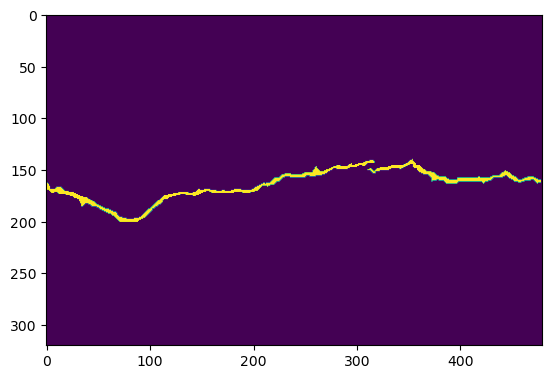

In [170]:
gt['groundTruth'][0, 0][0]
plt.imshow(gt['groundTruth'][0, 0][0])

In [171]:
img = plt.imread(os.path.join(image_path , '038.jpg'))

print(img.shape)
print(img.max())
print(img.min())
print(len(np.unique(img//16)))

(320, 480, 3)
248
41
14


In [172]:
import matplotlib.colors as colors
sample = os.path.join(image_path, '001.jpg')
img_whole = cv2.cvtColor(cv2.imread(sample), cv2.COLOR_BGR2RGB)
colors, counts = np.unique(img_whole, return_counts=True)
print(len(colors), colors.min(), colors.max(),counts.mean(), counts.max(), counts.min())

173 36 228 2663.583815028902 15872 1


In [173]:
from math import ceil

i, j = 1, 2
img = img_whole[i * 80:(i + 1) * 80, j * 80:(j + 1) * 80]

# plt.imshow(img_patch)
# plt.xlabel('X Label')
# plt.ylabel('Y Label')
img_patch = img

nodes = []
height, width = img_patch.shape[0], img_patch.shape[1]
unit_size = 8

patch_x_max = ceil(height / unit_size)
patch_y_max = ceil(width / unit_size)

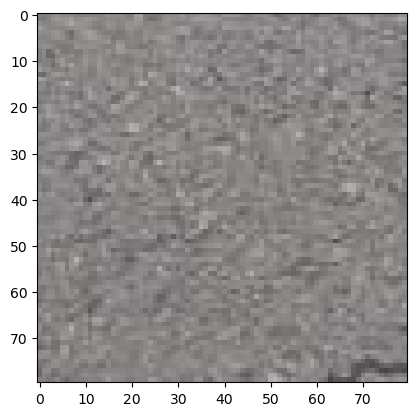

In [174]:
plt.imshow(img)

In [175]:
colors, counts = np.unique(img.reshape(-1, 3), return_counts=True, axis=0)
print(len(colors), counts.mean(), counts.max(), counts.min())
# list(zip(colors, counts, (counts / 6400 * 100)))

311 20.578778135048232 141 1


In [186]:
from sklearn.manifold import TSNE
from sklearn.metrics import pairwise_distances
from colormath.color_objects import sRGBColor, LabColor
from colormath.color_conversions import convert_color
from colormath.color_diff import delta_e_cie2000
import warnings
warnings.filterwarnings("ignore")

def color_difference(color1, color2):
    rgb_color1 = sRGBColor(rgb_r=color1[0],
                           rgb_g=color1[1],
                           rgb_b=color1[2],
                           is_upscaled=True)
    rgb_color2 = sRGBColor(rgb_r=color2[0],
                           rgb_g=color2[1],
                           rgb_b=color2[2],
                           is_upscaled=True)
    lab_color1 = convert_color(rgb_color1, LabColor)
    lab_color2 = convert_color(rgb_color2, LabColor)
    delta_e = delta_e_cie2000(lab_color1, lab_color2)
    # fix no asscalar problem by replacing by ndarray.item
    return delta_e


distances = pairwise_distances(colors, metric=color_difference, n_jobs=-1)
tsne = TSNE(n_components=1,
            metric='precomputed',
            learning_rate='auto',
            n_iter=500)
tsne_result = tsne.fit_transform(distances)
tsne_result.shape

(311, 1)

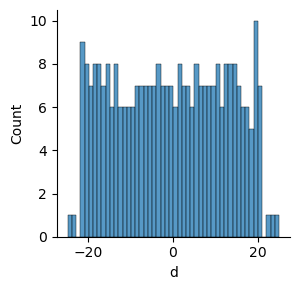

In [177]:
import seaborn as sns

data = pd.DataFrame(tsne_result,columns=['d'])
sns.FacetGrid(data).map(sns.histplot, 'd', bins=50).add_legend()

In [178]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=16)
cluster  = km.fit_predict(tsne_result)

In [179]:
uni, counts = np.unique(cluster, return_counts=True)
uni, counts

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15],
       dtype=int32),
 array([20, 18, 21, 24, 18, 22, 24, 18, 21, 20, 22, 21, 22, 21, 16,  3]))

In [180]:
min_tsne = tsne_result.min()
max_tsne = tsne_result.max()

for i in range(patch_x_max):
    for j in range(patch_y_max):
        if (i + 1) * unit_size < height and (j + 1) * unit_size < width:
            patch = img[i * unit_size:(i + 1) * unit_size,
                        j * unit_size:(j + 1) * unit_size]
        elif (i + 1) * unit_size >= height and (j + 1) * unit_size < width:
            patch = img[i * unit_size:, j * unit_size:(j + 1) * unit_size]
        elif (i + 1) * unit_size < height and (j + 1) * unit_size >= width:
            patch = img[i * unit_size:(i + 1) * unit_size, j * unit_size:]
        elif (i + 1) * unit_size >= height and (j + 1) * unit_size >= width:
            patch = img[i * unit_size:, j * unit_size:]

        if len(patch.shape) > 2:  # rgb
            uni_c, counts = np.unique(patch.reshape(-1, 3),
                                        return_counts=True,
                                        axis=0)
        else:  # gray
            uni_c, counts = np.unique(patch, return_counts=True)

        # define each patch as a node in the graph
        for c, count in zip(uni_c, counts):
            density = count / (patch.shape[0] * patch.shape[1])
            if density < 0.05:
                continue
            cur_node = dict()
            cur_node['i'] = np.array(i)
            cur_node['j'] = np.array(j)
            cur_node['density'] = density * unit_size * unit_size
            color_index = np.nonzero(np.abs((colors -
                                             c)).sum(axis=-1) == 0)[0][0]
            c_val = cluster[color_index]
            cur_node['c'] = c_val

            nodes.append(cur_node)

nodesframe = pd.DataFrame(nodes)

In [181]:
edges = []
for node_index in range(nodesframe.shape[0]):
    node = nodesframe.iloc[node_index]
    adj_nodes = nodesframe.loc[(nodesframe['i'] >= node['i'] - 1)
                               & (nodesframe['i'] <= node['i'] + 1) &
                               (nodesframe['j'] >= node['j'] - 1) &
                               (nodesframe['j'] <= node['j'] + 1) &
                               (nodesframe['c'] >= node['c'] - 1) &
                               (nodesframe['c'] <= node['c'] + 1)]

    for adj_nodes_index in adj_nodes.index:
        if adj_nodes_index != node_index:
            cur_edge = dict()
            cur_edge['from_node'] = node_index
            cur_edge['to_node'] = adj_nodes_index

            edges.append(cur_edge)

edgesframe = pd.DataFrame(edges)

In [182]:
edgesframe.head()

,from_node,to_node
0,0,1
1,0,4
2,0,34
3,1,0
4,1,4


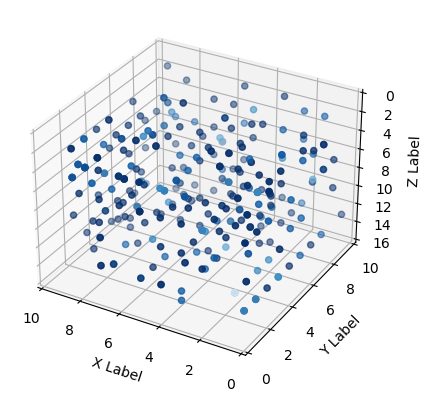

In [184]:
xdata, ydata,cdata,den = [],[],[],[]
for i in range(patch_x_max):
    for j in range(patch_y_max):
        patch = img[i * unit_size:(i + 1) * unit_size,
                          j * unit_size:(j + 1) * unit_size]
        uni_c, counts = np.unique(patch.reshape(-1, 3),
                                          return_counts=True,
                                          axis=0)
        for c, count in zip(uni_c, counts):
            density = count  / 64
            if density >= 0.05:
                den.append(density* unit_size * unit_size)
                xdata.append(i)
                ydata.append(j)
                color_index = np.nonzero(np.abs((colors -
                                                c)).sum(axis=-1) == 0)[0][0]
                
                # c_val = ((tsne_result[color_index][0] - min_tsne) /
                #     (max_tsne - min_tsne + 1e-5) * 16) // 1
                c_val = cluster[color_index]
                cdata.append(c_val)



fig = plt.figure()
ax = plt.axes(projection='3d')
ax.set_xlim((10,0))
ax.set_ylim((0, 10))
ax.set_zlim((16,0))
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
ax.scatter3D(xdata, ydata, cdata, c=den, cmap='Blues_r')

# NEU-CLS

In [ ]:
pip install patool

In [ ]:
import patoolib
patoolib.extract_archive("/nfs4-p1/gj/datasets/NEU surface defect database.rar", outdir="/nfs4-p1/gj/datasets/")

In [ ]:
import torch
from torch import nn
from torch import optim
import glob
import os
import numpy as np
import matplotlib.pyplot as plt 
import cv2
import seaborn

np.random.seed(928)
torch.manual_seed(928)

In [ ]:
device = torch.device("cuda:0")

datasets_root = "/nfs4-p1/gj/datasets/"
dataset_name = "NEU-CLS"
graph_data_root = "/nfs4-p1/gj/DEFECT2022/data/"

class_names = ["RS","In","Pa","Sc","PS","Cr"]
image_size = 200 # hight = width
class_num = 300 # 300 images in one class

In [ ]:
sample = plt.imread(datasets_root + dataset_name+"/Cr_1.bmp")
print(type(sample))
print(sample.shape)
print(sample.size)
print(sample.max())
print(sample.min())
plt.imshow(sample, cmap='gray')
plt.show()

In [ ]:
unit_size = 10
color_unit_size = 16

import pandas as pd

sample = sample // color_unit_size
print(sample.max())

In [ ]:
nodes = []
patch_x_max = int(image_size/unit_size)
patch_y_max = patch_x_max

for i in range(patch_x_max):
    for j in range(patch_y_max):
        patch = sample[i * unit_size: (i + 1) * unit_size, j * unit_size: (j + 1) * unit_size]
        uni_c, counts = np.unique(patch, return_counts=True)
        
        for c, count in zip(uni_c, counts):
            cur_node = dict()
            cur_node['i'] = np.array(i)
            cur_node['j'] = np.array(j)
            cur_node['c'] = np.array(c)
            cur_node['density'] = count / patch.size

            nodes.append(cur_node)
            
# print(len(nodes))
nodesframe = pd.DataFrame(nodes)
# pd.set_option('display.max_rows', 50)
# print(nodesframe)

In [ ]:
nodesframe.to_csv(graph_data_root+dataset_name+"/nodes.csv", index_label='node_id')

In [ ]:
edges = []
print(nodesframe.shape)

for node_index in range(nodesframe.shape[1]):
    node = nodesframe.iloc[node_index]
    # print(node)
    adj_nodes = nodesframe.loc[(nodesframe['i']>=node['i']-1)&(nodesframe['i']<=node['i']+1)&
                           (nodesframe['j']>=node['j']-1)&(nodesframe['j']<=node['j']+1)&
                           (nodesframe['c']>=node['c']-1)&(nodesframe['c']<=node['c']+1)]
    # print(adj_nodes)
    for adj_nodes_index in adj_nodes.index:
        # print(adj_nodes_index)
        if adj_nodes_index != node_index:
            cur_edge = dict()
            cur_edge['from_node'] = node_index
            cur_edge['to_node'] = adj_nodes_index

            edges.append(cur_edge)

# print(len(edges))
edgesframe = pd.DataFrame(edges)
# print(edgesframe)

In [ ]:
edgesframe.to_csv(graph_data_root+dataset_name+"/edges.csv", index=False)

# KSDD

In [ ]:
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import multiprocessing as mp

datasets_root = "/nfs4-p1/gj/datasets/AnomalyDetection/"
graph_data_root = "/nfs4-p1/gj/DEFECT2022/data/"

dataset_name = "KSDD"
dir_names = os.listdir(os.path.join(datasets_root, dataset_name))
print(len(dir_names))
unit_size = 50
color_unit_size = 16

In [ ]:
from math import ceil


label_list = glob.glob(
    os.path.join(datasets_root, dataset_name, dir_names[0], f'*.bmp'))
img_list = glob.glob(
    os.path.join(datasets_root, dataset_name, dir_names[0], f'*.jpg'))

label = plt.imread(
    os.path.join(datasets_root, dataset_name, dir_names[0], label_list[1]))
img = plt.imread(
    os.path.join(datasets_root, dataset_name, dir_names[0], img_list[1]))

label = plt.imread('/nfs4-p1/gj/datasets/AnomalyDetection/KSDD/kos02/Part6_label.bmp')
img = plt.imread('/nfs4-p1/gj/datasets/AnomalyDetection/KSDD/kos02/Part6.jpg')
print('img.shape:', img.shape)
print('img.max:', img.max())
print('label.max:', label.max())
height, width = img.shape[0], img.shape[1]
img = img // color_unit_size

patch_x_max = ceil(height / unit_size)
patch_y_max = ceil(width / unit_size)
print(patch_x_max, patch_y_max)

In [ ]:
print(label.max())
print(label.min())
print(label.max()== label.min())

In [ ]:
class_index = 0 if label.max() == label.min() else 1
print(class_index)

In [ ]:
nodes = []
# divide the whole image into several patch
for i in range(patch_x_max):
    for j in range(patch_y_max):
        if (i + 1) * unit_size < height and (j + 1) * unit_size < width:
            patch = img[i * unit_size:(i + 1) * unit_size,
                        j * unit_size:(j + 1) * unit_size]
        elif (i + 1) * unit_size >= height and (j + 1) * unit_size < width:
            patch = img[i * unit_size:, j * unit_size:(j + 1) * unit_size]
        elif (i + 1) * unit_size < height and (j + 1) * unit_size >= width:
            patch = img[i * unit_size:(i + 1) * unit_size, j * unit_size:]
        elif (i + 1) * unit_size >= height and (j +
                                                1) * unit_size >= width:
            patch = img[i * unit_size:, j * unit_size:]

        uni_c, counts = np.unique(patch, return_counts=True)

        # define each patch as a node in the graph
        for c, count in zip(uni_c, counts):
            cur_node = dict()
            cur_node['i'] = np.array(i)
            cur_node['j'] = np.array(j)
            cur_node['c'] = np.array(c)
            cur_node[
                'density'] = count * unit_size * unit_size / patch.size

            nodes.append(cur_node)

nodesframe = pd.DataFrame(nodes)

In [ ]:
nodesframe.to_csv('/nfs4-p1/gj/DEFECT2022/data/node.csv',
                  index_label='node_id')


In [ ]:
edges = []
# for node_index in range(nodesframe.shape[0]):
#     node = nodesframe.iloc[node_index]
#     adj_nodes = nodesframe.loc[(nodesframe['i'] >= node['i'] - 1)
#                                 & (nodesframe['i'] <= node['i'] + 1) &
#                                 (nodesframe['j'] >= node['j'] - 1) &
#                                 (nodesframe['j'] <= node['j'] + 1) &
#                                 (nodesframe['c'] >= node['c'] - 1) &
#                                 (nodesframe['c'] <= node['c'] + 1)]
#     if len(adj_nodes) > 27:
#         print(adj_nodes.shape)
#         print(node)
#         print(len(node))
#         print(adj_nodes)
#         break
#     for adj_nodes_index in adj_nodes.index:
#         if adj_nodes_index != node_index:
#             cur_edge = dict()
#             cur_edge['from_node'] = node_index
#             cur_edge['to_node'] = adj_nodes_index

#             edges.append(cur_edge)

# edgesframe = pd.DataFrame(edges)

In [ ]:
import torch
torch.cuda.is_available()

In [ ]:
torch.rand((3,2)).cuda()